In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

# Making the Dataset

In [21]:
X, y = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=4,
    cluster_std=1.8,
    random_state=42
)

In [22]:
X.shape, y.shape

((1000, 2), (1000,))

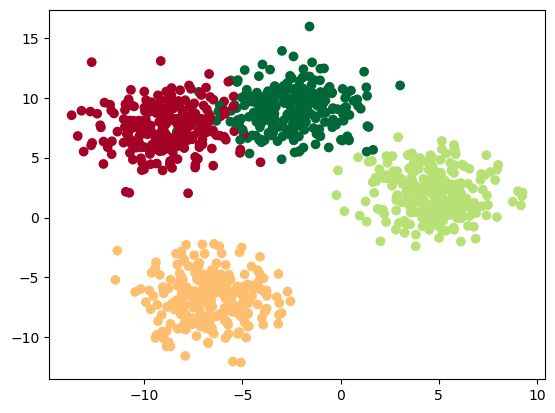

In [23]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlGn_r')
plt.show()

## Splitting the data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 2), (750,), (250, 2), (250,))

# Setting up Device agnostic code

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Constructing a Model
* Defining a Model
* Training the Model
* Testing the Model

## Defining the Model

In [27]:
class MultiClassModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_units=10):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  def forward(self, x):
    return self.model(x)

## Instantiating the model

In [28]:
torch.manual_seed(42)

model_0 = MultiClassModel(2, 4, 10).to(device)
model_0

MultiClassModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [29]:
list(model_0.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998],
         [ 0.5451,  0.1045],
         [-0.3301,  0.1802]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
          0.0667, -0.6984], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
           0.0346, -0.0997],
         [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
           0.1606, -0.1927],
         [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, -0.0055,
           0.2475, -0.2247],
         [ 0.0199, -0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874,
          -0.1886, -0.1886],
         [ 

In [30]:
next(model_0.parameters()).device

device(type='cuda', index=0)

## Setting data onto device

In [31]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device)

## Pre-train Predictions

In [32]:
y_logits = model_0(X_train)
y_logits[:5]    # WX

tensor([[-0.2354,  0.3079,  0.2288, -0.3404],
        [-0.2111,  0.2742,  0.2077, -0.3091],
        [ 0.0613,  0.1865,  0.1508, -0.1698],
        [-0.1930,  0.4140,  0.2967, -0.4214],
        [ 0.1338,  0.2445,  0.5063, -0.2322]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [33]:
model_0.eval()

with torch.inference_mode():
  y_probs = torch.softmax(y_logits, dim=1)
y_probs

tensor([[0.1918, 0.3303, 0.3052, 0.1727],
        [0.1980, 0.3216, 0.3009, 0.1795],
        [0.2487, 0.2819, 0.2720, 0.1974],
        ...,
        [0.1813, 0.3634, 0.3191, 0.1363],
        [0.2560, 0.2764, 0.2621, 0.2055],
        [0.2122, 0.2837, 0.2931, 0.2110]], device='cuda:0')

In [34]:
y_probs = torch.argmax(y_probs, dim=1)
y_probs[:5]

tensor([1, 1, 1, 1, 2], device='cuda:0')

## Setting Loss Function and Optimizer

In [35]:
loss_fn = nn.CrossEntropyLoss()  # Suitable for multiclass classification
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

## Training loop

In [36]:
torch.manual_seed(42)

epochs = 1000

# Training Loop
for epoch in range(epochs):

  # Making model predictions (forward pass)
  y_logits = model_0(X_train)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_preds = torch.argmax(y_pred_probs, dim=1)

  # Computing loss
  loss = loss_fn(y_logits, y_train)

  # Clearing gradients
  optimizer.zero_grad()

  # Backpropogation
  loss.backward()

  # Calculating Gradients and updating weights
  optimizer.step()

  # Validation step
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test)
    test_pred_probs = torch.softmax(test_logits, dim=1)
    test_preds = torch.argmax(test_pred_probs, dim=1)

    if epoch % 100 == 0:
      train_loss = loss
      test_loss = loss_fn(test_logits, y_test)

      train_acc = (y_preds == y_train).sum() / len(y_train)
      test_acc = (test_preds == y_test).sum() / len(y_test)

      print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch: 0 | Train Loss: 1.5093 | Test Loss: 1.4094 | Train Acc: 0.0427 | Test Acc: 0.0360
Epoch: 100 | Train Loss: 0.0763 | Test Loss: 0.0595 | Train Acc: 0.9747 | Test Acc: 0.9800
Epoch: 200 | Train Loss: 0.0670 | Test Loss: 0.0503 | Train Acc: 0.9747 | Test Acc: 0.9840
Epoch: 300 | Train Loss: 0.0638 | Test Loss: 0.0473 | Train Acc: 0.9760 | Test Acc: 0.9880
Epoch: 400 | Train Loss: 0.0616 | Test Loss: 0.0454 | Train Acc: 0.9760 | Test Acc: 0.9880
Epoch: 500 | Train Loss: 0.0599 | Test Loss: 0.0439 | Train Acc: 0.9760 | Test Acc: 0.9880


Epoch: 600 | Train Loss: 0.0585 | Test Loss: 0.0425 | Train Acc: 0.9760 | Test Acc: 0.9880
Epoch: 700 | Train Loss: 0.0572 | Test Loss: 0.0413 | Train Acc: 0.9760 | Test Acc: 0.9880
Epoch: 800 | Train Loss: 0.0561 | Test Loss: 0.0400 | Train Acc: 0.9773 | Test Acc: 0.9880
Epoch: 900 | Train Loss: 0.0551 | Test Loss: 0.0388 | Train Acc: 0.9773 | Test Acc: 0.9880


## Visualize

In [37]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

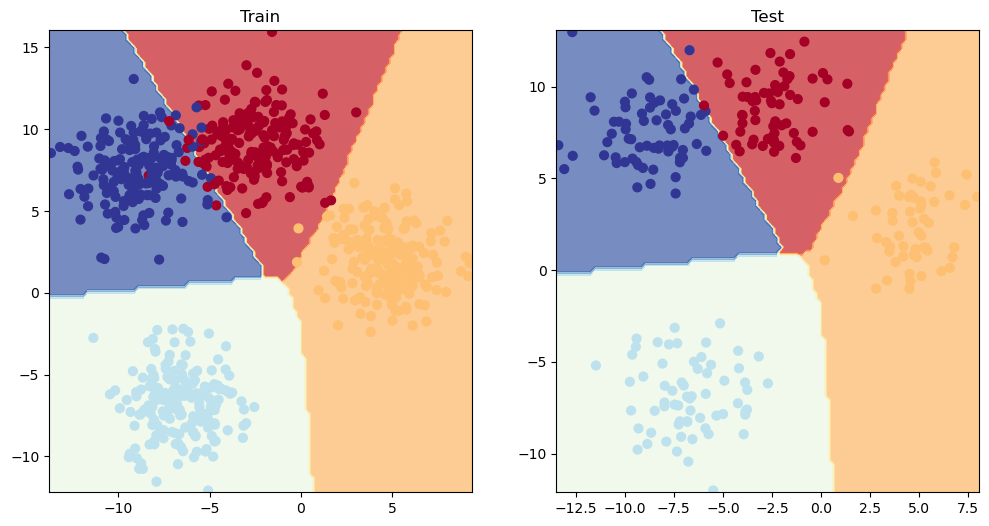

In [38]:
# Plotting decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)